In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# our module
from preprocess import *

In [2]:
df = sr_data_reader(p = .01)

### language features

In [ ]:
# before we try to learn good values for theta 
# we need to construct x

# x = information a students history learning a certain word

df.iloc[0,:]

In [ ]:
# (df['p_recall'] == (df['session_correct'])/(df['session_seen'])).sum() == df.shape[0]

# p_recall is the ratio of session_correct/session_seen

# p_recall is "y" "ground truth"

# predicted_p_recall is "y_hat" "prediction"

# error(p_recall,predicted_p_recall) <- we want this to be as small as possible

# if we can very reliably predict p_recall, what is the value of this in real-life terms?


In [ ]:
# get parts of speech

def lexeme_df(filename):

    import re
    df_single_col = pd.read_csv(filename, delimiter='\t', header=None, names=['line'])

    def split_line(line):
        parts = re.split(r'\s+', line, maxsplit=2)
        if len(parts) == 3:
            return parts
        return [None, None, None]

    df_split = df_single_col['line'].apply(split_line)
    df = pd.DataFrame(df_split.tolist(), columns=['lexeme', 'category', 'meaning'])

    return df

In [ ]:
lexemes = lexeme_df('lexeme_reference.txt')
lexemes.head()

In [ ]:
lexemes['lexeme'].nunique()

In [ ]:
# one-hot encoding
# dummy variables / indicator variables

# df.loc[0,"lexeme_string"]

"<det><def><nt><sg><nom>"

# det, df, nt, sg, nom + 87 more 

# word | det | def | nt | sg | nom | ...
# das  |  1  | 1   | 1  | 1  |  1  | 0 ...



# look for the first <, remove everything to the left
# then remove <, >

# 

def extract_right_of_lt(text):
    import re
    match = re.search(r'<(.*)', text)
    return match.group(1) if match else ''




In [ ]:
df['lexeme_string'] = df['lexeme_string'].apply(extract_right_of_lt)
df['lexeme_string'] = df['lexeme_string'].str.replace("<"," ")
df['lexeme_string'] = df['lexeme_string'].str.replace(">","")
df['lexeme_string'] = df['lexeme_string'].str.replace("*","")
df['lexeme_string'] = df['lexeme_string'].str.replace("/","")
df['lexeme_string']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
vectorized_words = vectorizer.fit_transform(df['lexeme_string'])
vectorized_df = pd.DataFrame(vectorized_words.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

In [ ]:
# no longer optimizing this for now,
# i want to talk about specifying the model
# we'll return to this

vectorized_df.head()

In [ ]:
vectorized_df.sum().sort_values()

In [ ]:
# curious about most common parts of speech.
# how different parts of speech correspond to rate of correct responses

#
vectorized_df.sum().sort_values(ascending=False)[0:20].plot(kind = "bar",title="most common parts of speech")
plt.show()


In [ ]:
# p_recall 

df = pd.concat([df,vectorized_df],axis=1)
df.shape

In [ ]:
df.drop(columns = ['lexeme_string'],inplace=True)

In [ ]:
grp_by_columns = list(df.columns[~df.columns.isin(['p_recall','delta','user_id','timestamp',"history_seen", "history_correct", "session_seen",  "session_correct"])])

"""
select avg(p_recall)
from df
group by var1

select avg(p_recall)
from df
group by var2

...

select avg(p_recall)
from df
group by varn

"""

"""

select avg(p_recall)
from df
group by var1, ..., varn

"""

# 1515 binary vectors (one for each part of speech)

# 0 avg(p_recall)
# 1 avg(p_recall)

# df.drop(columns = grp_by_columns).mean(axis=1)



# df[grp_by_columns].mean(axis = 1)

list_of_recall_variation_by_column = []

for col in grp_by_columns:

    variation_of_means = df.groupby(col)['p_recall'].mean().std()

    variation_dict = {"column_name":col,
                      "variation_of_means":variation_of_means}

    list_of_recall_variation_by_column.append(variation_dict)

recall_variation_by_column = pd.DataFrame(list_of_recall_variation_by_column)
    
# col_name, std of group means

#### fitting

In [ ]:
from spaced_repetition import *
import torch.optim as optim


### Leitner

In [3]:
from leitner import *

leitner = leitner_model()
leitner_x, leitner_delta = leitner_data(df)

leitner_predicted_p_recall = leitner.predict(leitner_x,leitner_delta)

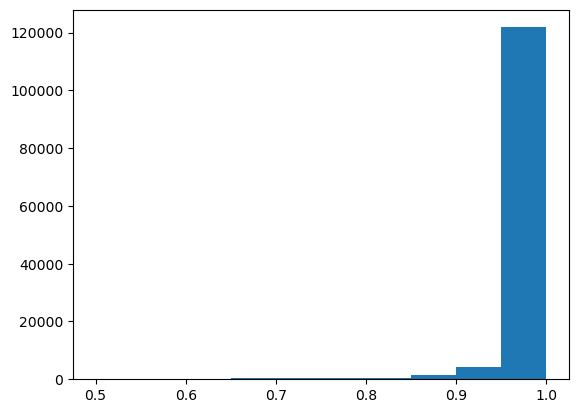

In [4]:
plt.figure()
plt.hist(leitner_predicted_p_recall.detach().numpy())
plt.show()

### HLR

In [ ]:
import torch.optim as optim

input_dim = 2 # number of features (history_seen, history_correct)
learning_rate = 0.001 # hyperparameter that we give the optimizer
num_epochs = 100 # 1 epoch = a single forward pass of all data  
alpha = 0.01 # controls the influence of the half-life term
lambda_reg = 0.01 # controls the influence of the penalty/regularization term

hlr = SpacedRepetition(input_dim, alpha, lambda_reg)
optimizer = optim.Adam(hlr.parameters(), lr=learning_rate) # default learning rate for adam is .001


In [ ]:
from utils import (mean_absolute_percentage_error,
                   root_mean_squared_error,
                   r_squared)

In [ ]:
metrics = {"epoch:"[],
           "batch":
           "training loss":[],
           ""}
metrics[]
for epoch in range(num_epochs):
    model.train()
    
    epoch_loss = 0.0
    for batch_x, batch_p, batch_h, batch_delta in dataloader:
        h_hat = model.forward(batch_x)
        p_hat = model.prediction(h_hat, batch_delta)
        
        loss = model.loss(batch_p, p_hat, batch_h, h_hat)
        # metrics
        mape = mean_absolute_percentage_error
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

In [ ]:
plt.plot(range(num_epochs), losses)
# plt.ylim(0,losses[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

In [ ]:
# observations
# we barely learned anything (the error hardly went down)
# maybe, we just need more data, more epochs, maybe hyperparameters are severely wrong.

# evaluation
# the error 
# human interpretable error
# R-squared 1 - (squared difference between predicted and observed)/(squared difference between observed and avg(observed))
# RMSE - root mean squared error
# avg absolute difference between p_recall and predicted p_recall

# note about our priorities
# from the pov of the user
# is the experience of learning worse when you know everything or when you know nothing. 
# getting really easy questions (difficulty of remembering)
# getting really hard questions (difficulty of remembering)

# A. if our error is really big (cumulative error) because we are making a lot of small mistakes, then maybe thats ok
# B. if our error is really big because we predict perfectly a lot of the time, but when we make a mistake, its a very big mistake

# B is very bad. A is not so bad. p_recall is .5 and we predict .47, that's not bad.

# calculate the residuals - (predicted - actual)

# side note: if you have experience with ML, you will be wondering why we're training the model on all of our data
# we are supposed to leave some aside. don't worry, we'll do this later

# getting predictions
predicted_h_hat = model.forward(x)
predicted_p_recall = model.prediction(predicted_h_hat.squeeze(),delta)

In [ ]:
plt.figure()
plt.hist(predicted_p_recall.detach().numpy(),color = "red",alpha = .3,label = 'predicted')
plt.hist(p.detach().numpy(),color = "blue",alpha = .3,label = 'observed')
plt.legend()
plt.show()

In [ ]:
# observations
# model overestimates p_recall 


In [ ]:
print(f"mean absolute percentage error: {mean_absolute_percentage_error(torch.tensor(simple_df['p_recall']),predicted_p_recall)}")

In [ ]:
print(f"r-squared: {r_squared(torch.tensor(simple_df['p_recall']),predicted_p_recall)}")

In [ ]:
# it's going to be really important to compare our half-life model (when eventually we get it right)
# to whatever system is in deployment currently
# compare to what duolingo is using to predict when to show a user a vocab word
# leitner is the legacy system
# we need to beat leitner
# therefore we need build leitner, otherwise we can't do the comparison.
